# Topic Modeling with Earnings Call Transcripts

## Imports & Settings

In [2]:
% matplotlib inline
import warnings
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import sparse

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, FloatRangeSlider

# spacy for language processing
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# sklearn for feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

# gensim for topic models
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

# topic model viz
import pyLDAvis
from pyLDAvis.gensim import prepare

# evaluate parameter settings
import statsmodels.api as sm

In [3]:
plt.style.use('fivethirtyeight')
pyLDAvis.enable_notebook()
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

In [84]:
PROJECT_DIR = Path().cwd().parent.parent
earnings_path = PROJECT_DIR / '03_alternative_data' / '02_earnings_calls' / 'transcripts' / 'parsed'
experiment_path = Path('experiments')
clean_text = Path('data', 'clean_text.txt')

In [125]:
stop_words = set(pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words', 
                         header=None, 
                         squeeze=True))

## Load Earnings Call Transcripts

In [11]:
documents = []
for transcript in earnings_path.iterdir():
    content = pd.read_csv(transcript / 'content.csv')
    documents.extend(content.loc[(content.speaker!='Operator') & (content.content.str.len() > 5), 'content'].tolist())

In [15]:
len(documents)

22766

## Explore Data

### Tokens per document

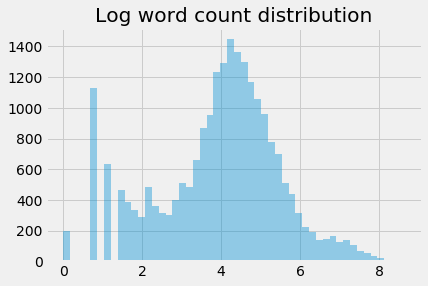

In [26]:
word_count = pd.Series(documents).str.split().str.len()
ax = sns.distplot(np.log(word_count), kde=False)
ax.set_title('Log word count distribution');

In [18]:
word_count.describe(percentiles=np.arange(.1, 1.0, .1))

count   22,766.00
mean       143.95
std        295.12
min          1.00
10%          4.00
20%         13.00
30.0%       31.00
40%         47.00
50%         64.00
60%         85.00
70%        115.00
80%        167.00
90%        288.00
max      5,718.00
dtype: float64

In [13]:
token_count = Counter()
for i, doc in enumerate(documents, 1):
    if i % 5000 == 0:
        print(i, end=' ', flush=True)
    token_count.update(doc.split())

5000 10000 15000 20000 

### Most frequent tokens

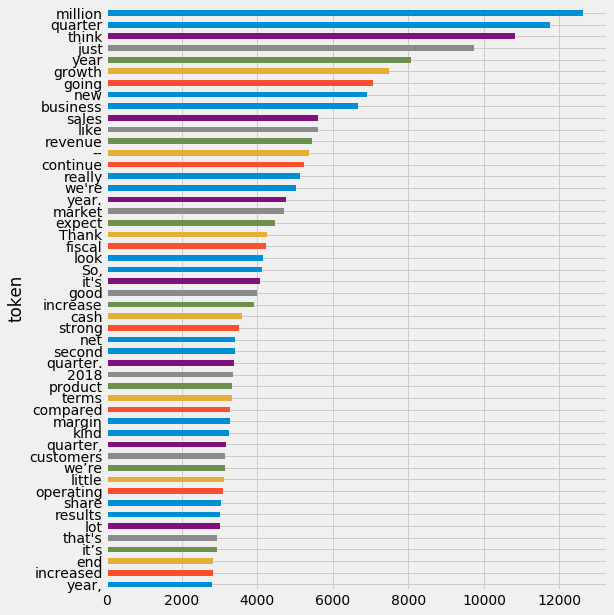

In [14]:
(pd.DataFrame(token_count.most_common(), columns=['token', 'count'])
 .pipe(lambda x: x[~x.token.str.lower().isin(stop_words)])
 .set_index('token')
 .squeeze()
 .iloc[:50]
 .sort_values()
 .plot
 .barh(figsize=(8, 10)));

## Preprocess Transcripts

In [275]:
def clean_doc(d):
    doc = []
    for t in d:
        if not any([t.is_stop, t.is_digit, not t.is_alpha, t.is_punct, t.is_space, t.lemma_ == '-PRON-']):        
            doc.append(t.lemma_)
    return ' '.join(doc)    

In [ ]:
clean_docs = []
for i, document in enumerate(documents, 1):
    if i % 1000 == 0: 
        print(f'{i/len(documents):.2%}', end=' ', flush=True)
    doc = nlp(document)
    cleaned = clean_doc(doc)
    if len(cleaned) > 0:
        clean_docs.append(cleaned)

In [280]:
clean_text.write_text('\n'.join(clean_docs))

8981914

## Vectorize data

In [127]:
docs = []
for line in clean_text.read_text().split('\n'):
    line = [t for t in line.split() if t not in stop_words]
    if len(line) > 10:
        docs.append(' '.join(line))

len(docs)

16156

In [128]:
token_count = Counter()
for i, doc in enumerate(docs, 1):
    if i % 5000 == 0:
        print(i, end=' ', flush=True)
    token_count.update(doc.split())
token_count = pd.DataFrame(token_count.most_common(), columns=['token', 'count'])    

5000 10000 15000 

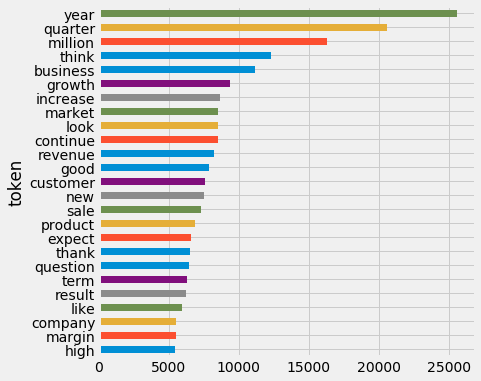

In [131]:
(token_count
 .set_index('token')
 .squeeze()
 .iloc[:25]
 .sort_values()
 .plot
 .barh(figsize=(6, 6)));

In [136]:
frequent_words = token_count.head(50).token.tolist()
binary_vectorizer = CountVectorizer(max_df=1.0,
                             min_df=1,
                             stop_words=frequent_words,
                             max_features=None,
                             binary=True)

binary_dtm = binary_vectorizer.fit_transform(docs)

n_docs, n_tokens = binary_dtm.shape
doc_freq = pd.Series(np.array(binary_dtm.sum(axis=0)).squeeze()).div(binary_dtm.shape[0])
max_unique_tokens = np.array(binary_dtm.sum(axis=1)).squeeze().max()

In [137]:
df_range = FloatRangeSlider(value=[0.0, 1.0],
                            min=0,
                            max=1,
                            step=0.0001,
                            description='Doc. Freq.',
                            disabled=False,
                            continuous_update=True,
                            orientation='horizontal',
                            readout=True,
                            readout_format='.1%',
                            layout={'width': '800px'})

@interact(df_range=df_range)
def document_frequency_simulator(df_range):
    min_df, max_df = df_range
    keep = doc_freq.between(left=min_df, right=max_df)
    left = keep.sum()

    fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
    updated_dtm = binary_dtm.tocsc()[:, np.flatnonzero(keep)]
    unique_tokens_per_doc = np.array(updated_dtm.sum(axis=1)).squeeze()
    sns.distplot(unique_tokens_per_doc, ax=axes[0], kde=False, norm_hist=False)
    axes[0].set_title('Unique Tokens per Doc')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('# Unique Tokens')
    axes[0].set_ylabel('# Documents (log scale)')
    axes[0].set_xlim(0, max_unique_tokens)    
    axes[0].yaxis.set_major_formatter(ScalarFormatter())

    term_freq = pd.Series(np.array(updated_dtm.sum(axis=0)).squeeze())
    sns.distplot(term_freq, ax=axes[1], kde=False, norm_hist=False)
    axes[1].set_title('Document Frequency')
    axes[1].set_ylabel('# Tokens')
    axes[1].set_xlabel('# Documents')
    axes[1].set_yscale('log')
    axes[1].set_xlim(0, n_docs)
#     axes[1].yaxis.set_major_formatter(ScalarFormatter())

    title = f'Document/Term Frequency Distribution | # Tokens: {left:,d} ({left/n_tokens:.2%})'
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

interactive(children=(FloatRangeSlider(value=(0.0, 1.0), description='Doc. Freq.', layout=Layout(width='800px'…

## Train & Evaluate LDA Model

In [189]:
def show_word_list(model, corpus, top=10, save=False):
    top_topics = model.top_topics(corpus=corpus, coherence='u_mass', topn=20)
    words, probs = [], []
    for top_topic, _ in top_topics:
        words.append([t[1] for t in top_topic[:top]])
        probs.append([t[0] for t in top_topic[:top]])

    fig, ax = plt.subplots(figsize=(model.num_topics*1.2, 5))
    sns.heatmap(pd.DataFrame(probs).T,
                annot=pd.DataFrame(words).T,
                fmt='',
                ax=ax,
                cmap='Blues',
                cbar=False)
    fig.tight_layout()
    if save:
        fig.savefig('earnings_call_wordlist', dpi=300)

In [181]:
def show_coherence(model, corpus, tokens, top=10, cutoff=0.01):
    top_topics = model.top_topics(corpus=corpus, coherence='u_mass', topn=20)
    word_lists = pd.DataFrame(model.get_topics().T, index=tokens)
    order = []
    for w, word_list in word_lists.items():
        target = set(word_list.nlargest(top).index)
        for t, (top_topic, _) in enumerate(top_topics):
            if target == set([t[1] for t in top_topic[:top]]):
                order.append(t)

    fig, axes = plt.subplots(ncols=2, figsize=(15,5))
    title = f'# Words with Probability > {cutoff:.2%}'
    (word_lists.loc[:, order]>cutoff).sum().reset_index(drop=True).plot.bar(title=title, ax=axes[1]);

    umass = model.top_topics(corpus=corpus, coherence='u_mass', topn=20)
    pd.Series([c[1] for c in umass]).plot.bar(title='Topic Coherence', ax=axes[0])
    fig.tight_layout();

In [184]:
def show_top_docs(model, corpus, docs):
    doc_topics = model.get_document_topics(corpus)
    df = pd.concat([pd.DataFrame(doc_topic, 
                                 columns=['topicid', 'weight']).assign(doc=i) 
                    for i, doc_topic in enumerate(doc_topics)])

    for topicid, data in df.groupby('topicid'):
        print(topicid, docs[int(data.sort_values('weight', ascending=False).iloc[0].doc)])
        print(pd.DataFrame(exp_lda.show_topic(topicid=topicid)))

### Vocab Settings

In [138]:
min_df = .005
max_df=.5
ngram_range=(1, 1)
binary = False

In [139]:
vectorizer = CountVectorizer(stop_words=frequent_words,
                             min_df=min_df,
                             max_df=max_df,
                             ngram_range=ngram_range,
                             binary=binary)

In [140]:
dtm = vectorizer.fit_transform(docs)
tokens = vectorizer.get_feature_names()
dtm.shape

(16156, 1563)

In [141]:
corpus = Sparse2Corpus(dtm, documents_columns=False)
id2word = pd.Series(tokens).to_dict()
dictionary = Dictionary.from_corpus(corpus, id2word)

### Model Settings

In [177]:
num_topics=15
chunksize=2000
passes=25
update_every=None
alpha='auto'
eta='auto'
decay=0.5
offset=1.0
eval_every=None
iterations=50
gamma_threshold=0.001
minimum_probability=0.01
minimum_phi_value=0.01
per_word_topics=False

In [178]:
%%time
lda = LdaModel(corpus=corpus,
               id2word=id2word,
               num_topics=num_topics,
               chunksize=chunksize,
               update_every=update_every,
               alpha=alpha,
               eta=eta,
               decay=decay,
               offset=offset,
               eval_every=eval_every,
               passes=passes,
               iterations=iterations,
               gamma_threshold=gamma_threshold,
               minimum_probability=minimum_probability,
               minimum_phi_value=minimum_phi_value,
               random_state=42)

CPU times: user 2min 6s, sys: 0 ns, total: 2min 6s
Wall time: 2min 6s


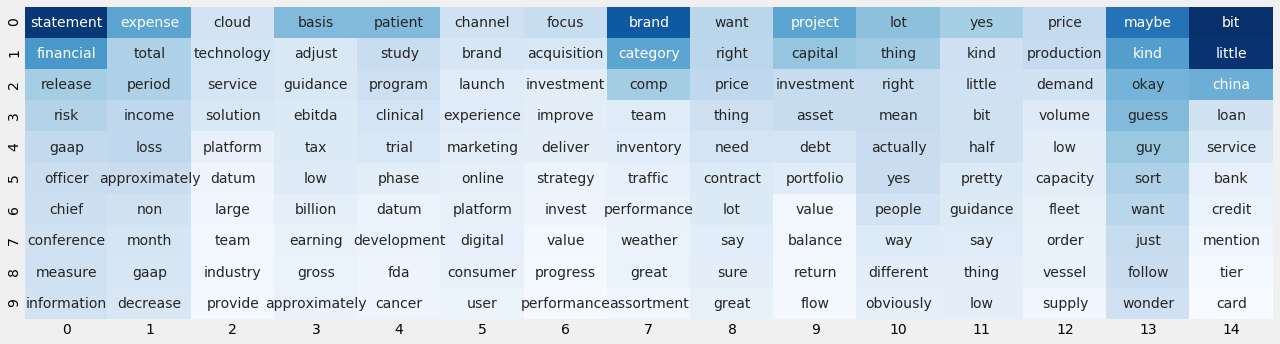

In [188]:
show_word_list(model=lda, corpus=corpus, save=True)

### Topic Coherence

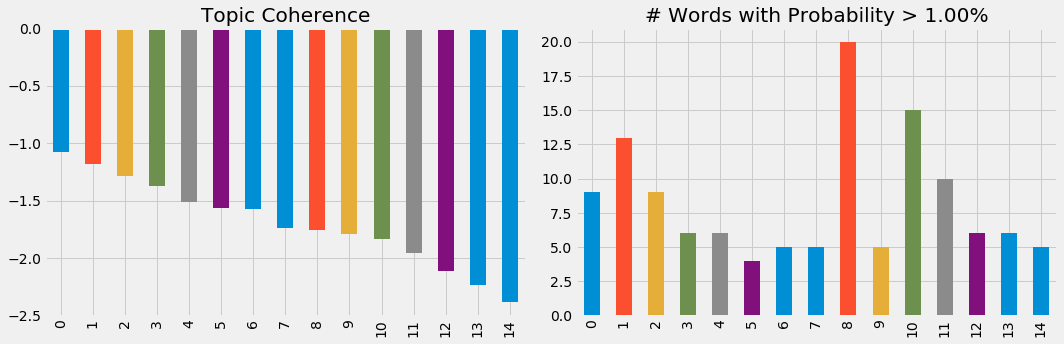

In [182]:
show_coherence(model=lda, corpus=corpus, tokens=tokens)

### pyLDAVis

In [183]:
vis = prepare(lda, corpus, dictionary, mds='tsne')
pyLDAvis.display(vis)

In [185]:
show_top_docs(model=lda, corpus=corpus, docs=docs)

0 okay question weather favorable quarter impact apparel business overall temperature nationally cold month quarter say like fourth quarter pleased progress deweather business apparel total come slightly chain average coat clearly underperform chain growth underdeveloped weather sensitive business home beauty help overcome weather outperform total quarter weather impact regional performance west southwest lead chain weather sensitive region northeast midwest chain second question term lady apparel trend closer chain average quarter say business outperform chain say prepared remark missy sportswear lead quarter trend lady apparel good active strong quarter strong performance moderate sportswear comp chain encouraging addition mention earlier add second svp lady apparel second half year expand leadership increase specialization business
            0    1
0     project 0.05
1  production 0.03
2      demand 0.03
3    capacity 0.02
4       order 0.02
5       fleet 0.02
6        cost 0.02
7

## Review Experiment Results

In [229]:
with pd.HDFStore('results.h5') as store:
    perplexity = store.get('perplexity')
    coherence = store.get('coherence')

In [230]:
perplexity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496 entries, 0 to 15
Data columns (total 8 columns):
vocab_size    496 non-null int64
test_vocab    496 non-null int64
min_df        496 non-null int64
max_df        496 non-null float64
binary        496 non-null bool
num_topics    496 non-null int64
passes        496 non-null int64
perplexity    496 non-null float64
dtypes: bool(1), float64(2), int64(5)
memory usage: 31.5 KB


In [231]:
coherence.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8370 entries, 0 to 713
Data columns (total 7 columns):
topic         8370 non-null int64
passes        8370 non-null object
num_topics    8370 non-null object
coherence     8370 non-null float64
min_df        8370 non-null int64
max_df        8370 non-null float64
binary        8370 non-null bool
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 465.9+ KB


### Parameter Settings: Impact on Perplexity

In [221]:
X = perplexity[['min_df', 'max_df', 'binary', 'num_topics','passes']]
X = pd.get_dummies(X, columns=X.columns, drop_first=True)
ols = sm.OLS(endog=perplexity.perplexity, exog=sm.add_constant(X))
model = ols.fit(cov_type='HC0')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             perplexity   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     75.71
Date:                Mon, 03 Dec 2018   Prob (F-statistic):          5.53e-116
Time:                        15:34:14   Log-Likelihood:                -2407.9
No. Observations:                 496   AIC:                             4848.
Df Residuals:                     480   BIC:                             4915.
Df Model:                          15                                         
Covariance Type:                  HC0                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           158.0331      5.804     27.227

### Parameter Settings: Impact on Coherence

In [232]:
X = coherence.drop('coherence', axis=1)
X = pd.get_dummies(X, columns=X.columns, drop_first=True)
ols = sm.OLS(endog=coherence.coherence, exog=sm.add_constant(X))
model = ols.fit(cov_type='HC0')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              coherence   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     237.0
Date:                Mon, 03 Dec 2018   Prob (F-statistic):               0.00
Time:                        15:50:17   Log-Likelihood:                -4925.0
No. Observations:                8370   AIC:                             9980.
Df Residuals:                    8305   BIC:                         1.044e+04
Df Model:                          64                                         
Covariance Type:                  HC0                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.5492      0.023    -66.490

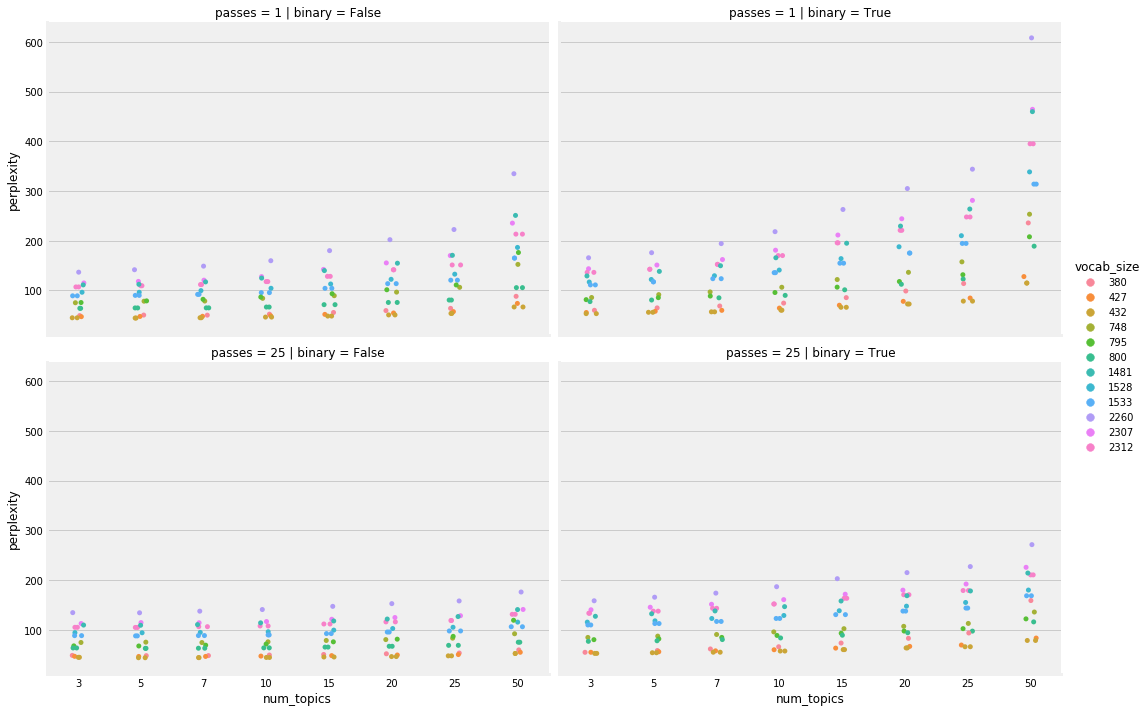

In [233]:
sns.catplot(x='num_topics',
            y='perplexity',
            data=perplexity,
            hue='vocab_size',
            col='binary',
            row='passes',
            kind='strip',
           aspect=1.5);

In [251]:
coherence.num_topics = coherence.num_topics.apply(lambda x: f'model_{int(x):0>2}')
perplexity.min_df = perplexity.min_df.apply(lambda x: f'min_df_{int(x):0>3}')

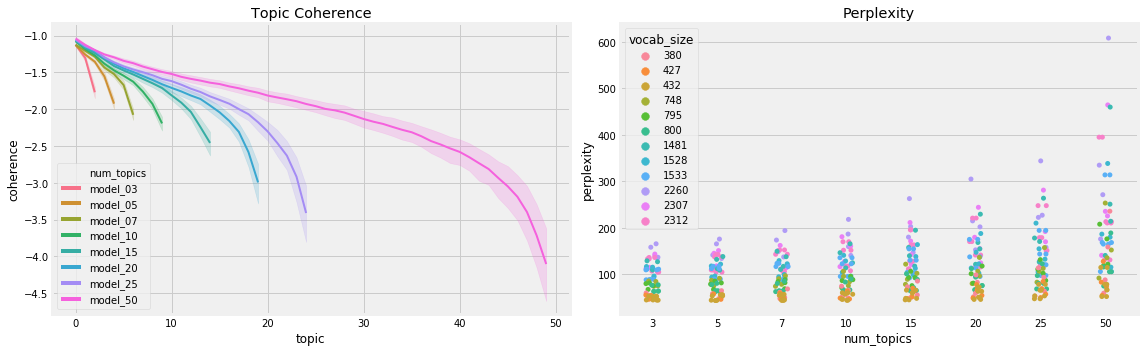

In [256]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))
data = coherence.sort_values('num_topics')
sns.lineplot(x='topic', y='coherence', hue='num_topics', data=data, lw=2, ax=axes[0])
axes[0].set_title('Topic Coherence')
sns.stripplot(x='num_topics', y='perplexity', hue='vocab_size', data=perplexity, lw=2, ax=axes[1])
axes[1].set_title('Perplexity')
fig.tight_layout()
fig.savefig('earnings_call_model_eval', dpi=300);

## Load Experiment

### Load Document-Term Matrix

In [190]:
max_df = .1    # [.1, .25, .5, 1.0]
min_df = 250   # [50, 100, 250, 500]
binary= False  # [True, False]

In [191]:
vocab_path = experiment_path / str(min_df) / str(max_df) / str(int(binary))
exp_dtm = sparse.load_npz(vocab_path / f'dtm.npz')
exp_tokens = pd.read_csv(vocab_path / f'tokens.csv', header=None, squeeze=True)
exp_dtm.shape

(22766, 748)

In [192]:
exp_id2word = exp_tokens.to_dict()
exp_corpus = Sparse2Corpus(exp_dtm, documents_columns=False)
exp_dictionary = Dictionary.from_corpus(exp_corpus, exp_id2word)

In [193]:
exp_train_dtm, exp_test_dtm = train_test_split(exp_dtm, test_size=.1)

In [194]:
exp_test_dtm

<2277x748 sparse matrix of type '<class 'numpy.int64'>'
	with 49568 stored elements in Compressed Sparse Row format>

In [195]:
exp_test_corpus = Sparse2Corpus(exp_test_dtm, documents_columns=False)

### Set Model Parameters

In [196]:
num_topics = 20 # [3, 5, 7, 10, 15, 20, 25, 50]
passes = 25    # [1, 25]

In [197]:
exp_model_path = vocab_path / str(num_topics) / str(passes)
exp_lda = LdaModel.load(str(exp_model_path / 'lda'))

In [198]:
2 ** (-exp_lda.log_perplexity(exp_test_corpus))

84.52873752805492

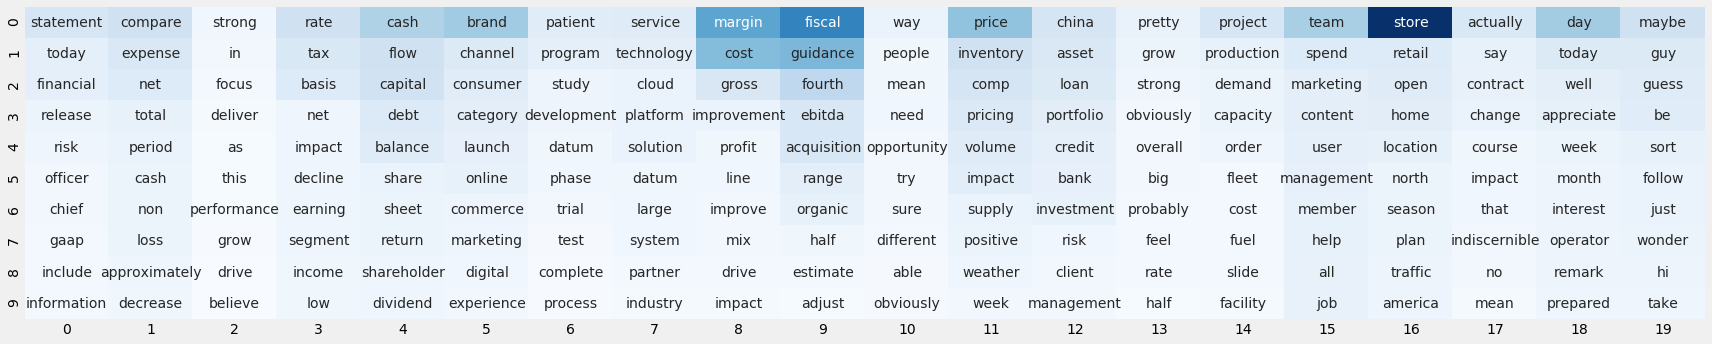

In [200]:
show_word_list(model=exp_lda, corpus=exp_corpus)

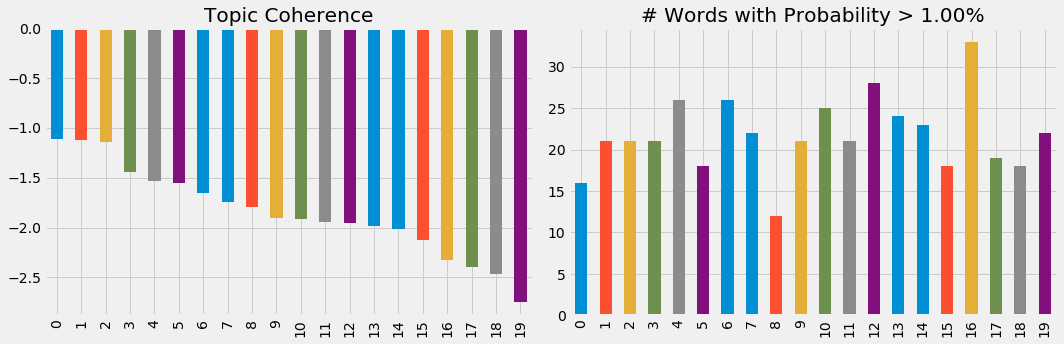

In [201]:
show_coherence(model=exp_lda, corpus=exp_corpus, tokens=exp_tokens)

In [202]:
exp_vis = prepare(exp_lda, exp_corpus, exp_dictionary, mds='tsne')
pyLDAvis.display(exp_vis)

### Review Documents by Topic

In [209]:
exp_docs = []
for line in clean_text.read_text().split('\n'):
        exp_docs.append(line)
len(exp_docs)

22745

In [207]:
doc_topics = exp_lda.get_document_topics(exp_corpus)
df = pd.concat([pd.DataFrame(doc_topic, columns=['topicid', 'weight']).assign(doc=i) for i, doc_topic in enumerate(doc_topics)])

In [210]:
for topicid, data in df.groupby('topicid'):
    print(topicid, exp_docs[int(data.sort_values('weight', ascending=False).iloc[0].doc)])
    print(pd.DataFrame(exp_lda.show_topic(topicid=topicid)))

0 no real update give time continue different clinical program hifu application so track update give far
            0    1
0     project 0.05
1  production 0.03
2      demand 0.03
3    capacity 0.02
4       order 0.02
5       fleet 0.02
6        cost 0.02
7        fuel 0.02
8       slide 0.02
9    facility 0.02
1 okay understand and second question multipart hopefully quick the ballast water treatment mention coast guard approval think important can feeling timing so schedule far number ship year what hire time associate ship fitting ballast water treatment system cost ship and cost expense amortize
            0    1
0     service 0.04
1  technology 0.04
2       cloud 0.03
3    platform 0.03
4    solution 0.03
5       datum 0.02
6       large 0.02
7      system 0.02
8     partner 0.02
9    industry 0.01
2 thank
             0    1
0    statement 0.05
1        today 0.03
2    financial 0.03
3      release 0.02
4         risk 0.02
5      officer 0.02
6        chief 0.02
7         gaap 